<a href="https://colab.research.google.com/github/S4b3/PITC-21-22/blob/main/classification_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sync Code

Clone the GitHub Repo


In [1]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

Cloning into 'training_camp_21_22'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 6), reused 25 (delta 5), pack-reused 0
Unpacking objects: 100% (29/29), done.


`Move to the Python Project root folder` and install requirements

In [2]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 38.6 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 554 kB 53.4 MB/s 
     |████████████████████████████████| 13.1 MB 47.3 MB/s 
     |████████████████████████████████| 1.1 MB 58.6 MB/s 
     |████████████████████████████████| 15.8 MB 29.3 MB/s 
     |████████████████████████████████| 438 kB 56.6 MB/s 
     |████████████████████████████████| 1.6 MB 61.6 MB/s 
     |████████████████████████████████| 5.8 MB 40.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-clustering

In [3]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

In [ ]:
!gdown 1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN -O  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN
To: /root/.kaggle/kaggle.json
100% 74.0/74.0 [00:00<00:00, 106kB/s]


Download the input file (training and test)

In [4]:
!mkdir -p data/task_1

In [5]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [6]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

 69% 16.0M/23.1M [00:00<00:00, 167MB/s]
100% 23.1M/23.1M [00:00<00:00, 194MB/s]
Archive:  pitc-2122-clustering.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


# Import packages

Move back to the Python project folder 

In [7]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


Set the Python Path variable to the source folder

In [8]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [9]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import csv
from sklearn.metrics import confusion_matrix
import tensorflow_decision_forests as tfdf

import training_camp_21_22.config
import training_camp_21_22.data.commercial_offer
import training_camp_21_22.models
import training_camp_21_22.view.classification

# Preprocess Data

Dowload the data

In [57]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    csv_df = pd.DataFrame(columns=[
      "userID",
      "legalNature",
      "citizenshipNoUSA",
      "billing_range.from_date",
      "billing_range.to_date",
      "fasciaF0ConsumoFatturato",
      "fasciaF1ConsumoFatturato",
      "fasciaF2ConsumoFatturato",
      "fasciaF3ConsumoFatturato",
      "fasciaF4ConsumoFatturato",
      "fasciaF5ConsumoFatturato",
      "fasciaF6ConsumoFatturato",
      "res_address_code",
      "res_address_value",
      "dom_address_code",
      "dom_address_value"
    ])


    d = {}
    labels = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[-1]) :
            # read consumer id
            id = row[0]

            # billing_range
            billing_range = bill['customData']['billing_range']
            energy = bill['customData']['energy']
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            

            d[i] = {
              'userID' : id,
              'legalNature' : bill['bamData']['items']['bamItem']['legalNature'],
              'citizenshipNoUSA' : bill['bamData']['items']['bamItem']['personInfo']['citizenshipNoUSA'],
              'billing_range.from_date' : billing_range['from_date'],
              'billing_range.to_date' : billing_range['to_date'],
              'f1' : energy['fasciaF1ConsumoFatturato'],
              'f2' : energy['fasciaF2ConsumoFatturato'],
              'f3' : energy['fasciaF3ConsumoFatturato'],
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value
            }
            i = i+1

          #labels[j] = {'user' : row[0] , 'cluster': int(row[1])}
          #j += 1


    return pd.DataFrame.from_dict(d, "index")#, pd.DataFrame.from_dict(labels, 'index')


features_df = convert_json_2_pd(json_input_path="/content/training_camp_21_22/data/task_1/test.csv")

10000it [00:03, 2553.97it/s]


Let's have a look at the collected data!

In [58]:
features_df.head()

,userID,legalNature,citizenshipNoUSA,billing_range.from_date,billing_range.to_date,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value
0,90019,PF,False,2021-11-01,2021-11-30,30.0,31.0,14.0,B794,Carmignano,B794,Carmignano
1,90019,PF,False,2021-08-01,2021-08-31,2.0,41.0,7.0,B794,Carmignano,B794,Carmignano
2,90025,PF,False,2022-02-01,2022-02-28,49.0,11.0,39.0,C422,Ceggia,C422,Ceggia
3,90025,PF,False,2021-08-01,2021-08-31,18.0,50.0,61.0,C422,Ceggia,C422,Ceggia
4,90030,PF,False,2022-06-01,2022-06-30,18.0,33.0,36.0,D170,Crispano,D170,Crispano


In [53]:
labels_df.head()

,user,cluster
0,6,1
1,13,0
2,14,1
3,17,2
4,34,2


Load the commercial offers

In [34]:
#Label 0
mono_oraria = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.28, "f2": 0.28, "f3": 0.28}, name="mono_oraria")

# Label 1
serale = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.31, "f2": 0.26, "f3": 0.26}, name="serale")

# Lael 2
notturna = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.56, "f2": 0.56, "f3": 0.}, name="notturna")

commercial_offers = [mono_oraria, serale, notturna]
class_names = [co.name for co in commercial_offers]

#Baseline Classifier

The label is computed by "extending" the mean consumptions over the whole year

In [54]:
def project_over_year(df, commercial_offers):
    
    def best_projected_offer(row):
        columns = [co.name for co in commercial_offers]
        cluster = np.argmin(row[columns])
        return cluster
        
    year_projection = 12 * df.groupby(by=["userID"]).mean()

    for offer in commercial_offers:
        year_projection[offer.name] = year_projection.apply(
            offer.compute_yearly_cost, axis=1)

    year_projection["cluster"] = year_projection.apply(
        best_projected_offer, axis=1)
    year_projection = year_projection.drop(
        [co.name for co in commercial_offers], axis=1)

    return year_projection


year_projection_df = project_over_year(
    features_df, commercial_offers)

Let's have a look at the projection!

In [55]:
year_projection_df.head()

,citizenshipNoUSA,f1,f2,f3,cluster
userID,,,,,
0,0.0,228.0,572.0,440.0,1
1,0.0,12.0,528.0,444.0,1
10,0.0,508.0,176.0,796.0,2
100,0.0,648.0,36.0,960.0,2
1000,0.0,396.0,654.0,102.0,1


Plotting the confusion matrix

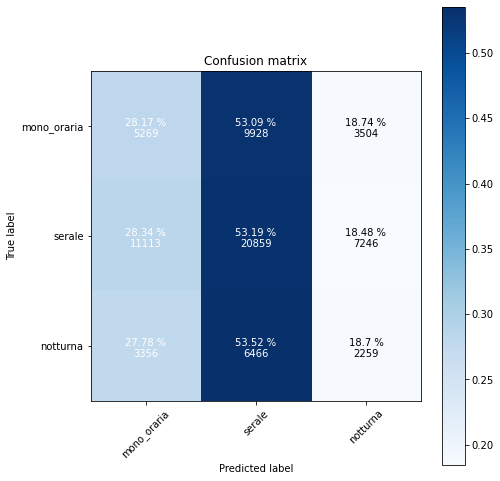

In [56]:
cm = confusion_matrix(
    labels_df["cluster"], year_projection_df["cluster"])

# Log the confusion matrix as an image summary
figure = training_camp_21_22.view.classification.plot_cm_with_labels(
    cm, class_names=class_names);

# Random Forest Classifier

Random Forest model

# Submit solution to Kaggle competition

In [38]:
test_submission = pd.DataFrame({
    "user": year_projection_df.index,
    "cluster": year_projection_df["cluster"]})
print(test_submission.head(10))
print(test_submission.shape)

         user  cluster
userID                
90000   90000        2
90001   90001        2
90002   90002        1
90003   90003        0
90004   90004        1
90005   90005        1
90006   90006        0
90007   90007        0
90008   90008        1
90009   90009        1
(10000, 2)


Create a termporary folder for submissions

In [28]:
!mkdir -p submissions

In [39]:
rf_labels_path = "submissions/baseline.csv"
test_submission.to_csv(rf_labels_path, index=False)

In [40]:
!kaggle competitions submit -c pitc-2122-clustering -f "submissions/baseline.csv" -m "Baseline classification"

100% 78.1k/78.1k [00:00<00:00, 240kB/s]
Successfully submitted to PITC 21/22 - Clustering